In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
from copy import deepcopy
import random
from time import perf_counter

In [2]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
# number of edges that are correctly colored 
def calculate_value(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

In [5]:
def initialize(graph):
    return [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]

In [6]:
def shaking(graph, coloring, k):
    new_coloring = deepcopy(coloring)
    chosen_indices = random.sample(range(len(coloring)), k)

    for idx in chosen_indices:
        new_coloring[idx] = random.randrange(1, len(graph.edges()))
    
    return new_coloring

In [7]:
def local_search_invert_first_improvement(graph, coloring, value, iter):
    
    new_coloring = deepcopy(coloring)
    improved = True
    best_iter = iter

    while improved:
        improved = False
        unbiased_order = list(range(len(new_coloring)))
        random.shuffle(unbiased_order)

        for i in unbiased_order:
            iter += 1
            old = new_coloring[i]
            new_coloring[i] = random.randrange(len(graph.edges))
            new_value = calculate_value(graph, new_coloring)

            if new_value < value:
                value = new_value
                improved = True
                best_iter = iter
                break
            else:
                new_coloring[i] = old
                
    return new_coloring, value, best_iter

In [8]:
def vns(graph, vns_params: dict):
    start_time = perf_counter()
    coloring = initialize(graph)
    value = calculate_value(graph, coloring)
    iter = 0
    best_iter = 0

    while perf_counter() - start_time < vns_params['time_limit']:
        for k in range(vns_params['k_min'], vns_params['k_max']):
            
            new_coloring = shaking(graph, coloring, k)
            new_value = calculate_value(graph, new_coloring)

            new_coloring, new_value, iter_local = local_search_invert_first_improvement(graph, new_coloring, new_value, iter) # intensification
            
            iter = iter_local

            if new_value < value or (new_value == value and random.random() < vns_params['move_prob']):
                if is_valid_coloring(graph, new_coloring):
                    if new_value < value:
                        best_iter = iter
                    value = new_value
                    coloring = deepcopy(new_coloring)
                   
    return coloring, best_iter

In [9]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [10]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [11]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts[1] = int(parts[1]) if len(parts) > 1 else 0
    return parts

In [12]:
vns_params = {
    'time_limit': 2,
    'k_min': 1,
    'k_max': 4,
    'move_prob': 0.05,
}

In [13]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):
    with open('./results/vns_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [14]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")
            
            start_time = time.time()
            graph = read_graph_from_file(filepath)
            coloring_result, iter = vns(graph, vns_params)
            end_time = time.time()
            
            write_output(graph, file, coloring_result, iter, start_time, end_time)         

Running test graph_101_edges.txt...
Minimum edge coloring found.
Number of colors: 69
Number of iterations: 157


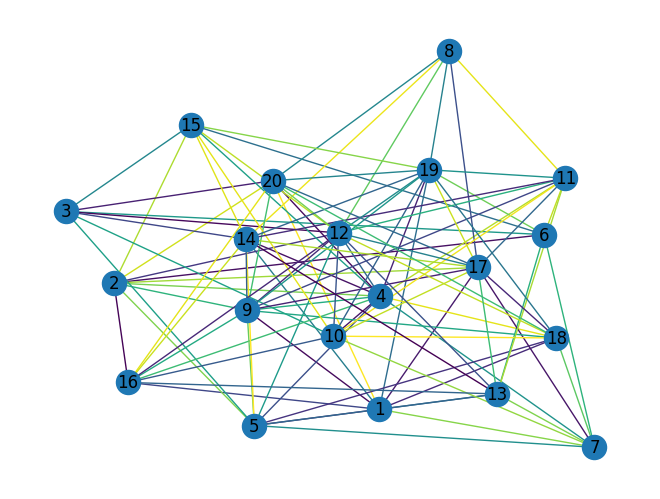

Time taken: 7.8204026222229 seconds

Running test graph_121_edges.txt...
Minimum edge coloring found.
Number of colors: 82
Number of iterations: 199


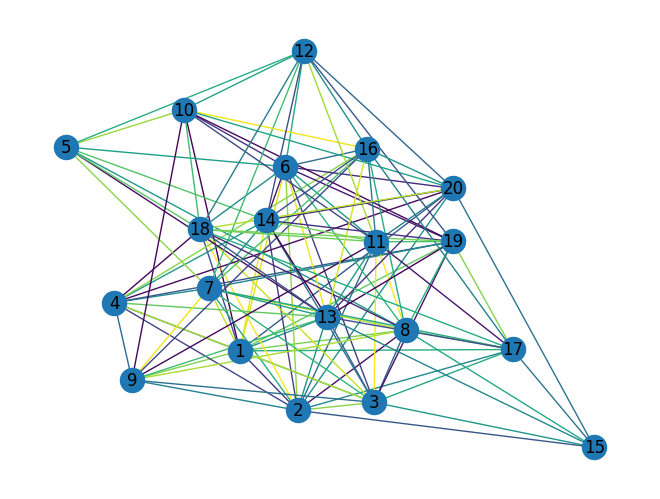

Time taken: 21.362142324447632 seconds

Running test graph_140_edges.txt...
Minimum edge coloring found.
Number of colors: 99
Number of iterations: 196


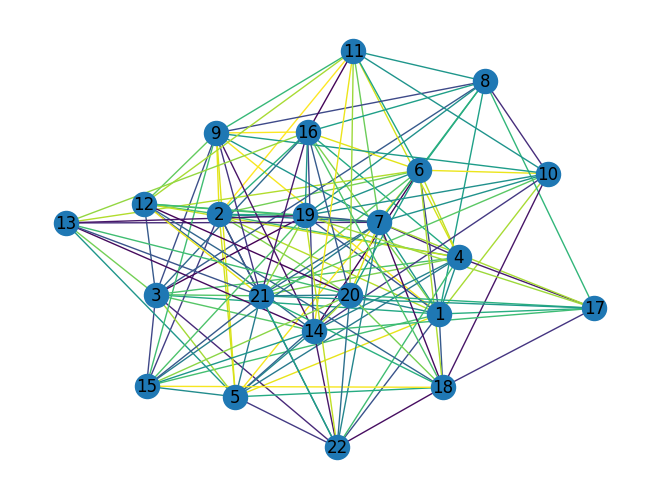

Time taken: 23.47921395301819 seconds

Running test graph_156_edges.txt...
Minimum edge coloring found.
Number of colors: 103
Number of iterations: 201


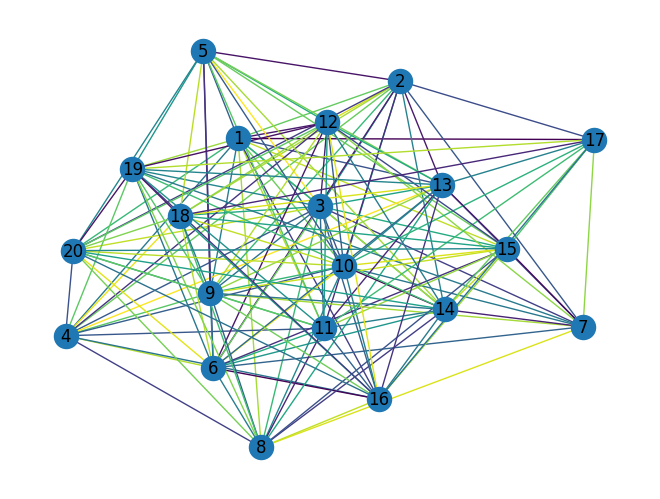

Time taken: 31.559659242630005 seconds

Running test graph_165_edges.txt...
Minimum edge coloring found.
Number of colors: 113
Number of iterations: 262


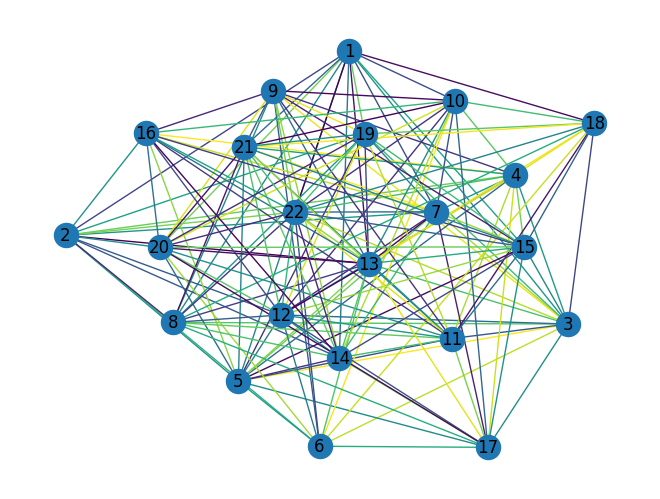

Time taken: 30.572967767715454 seconds

Running test graph_177_edges.txt...
Minimum edge coloring found.
Number of colors: 126
Number of iterations: 220


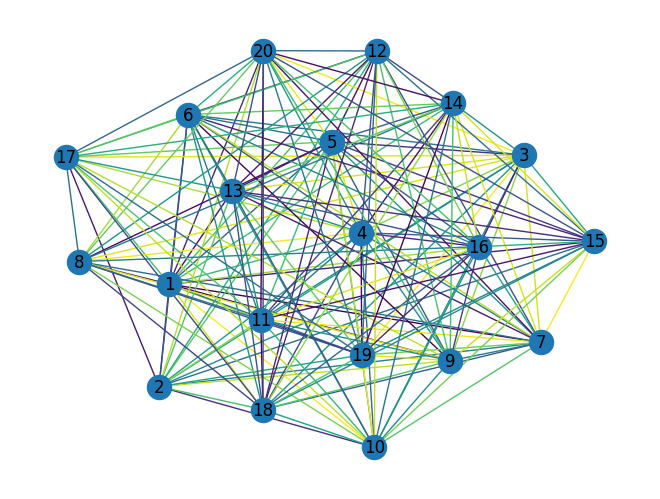

Time taken: 33.43371939659119 seconds

Running test graph_204_edges.txt...
Minimum edge coloring found.
Number of colors: 143
Number of iterations: 426


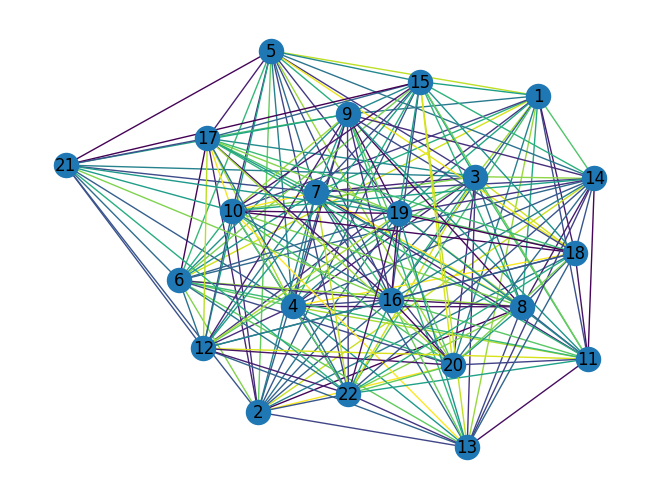

Time taken: 61.337332248687744 seconds

Running test graph_227_edges.txt...
Minimum edge coloring found.
Number of colors: 146
Number of iterations: 376


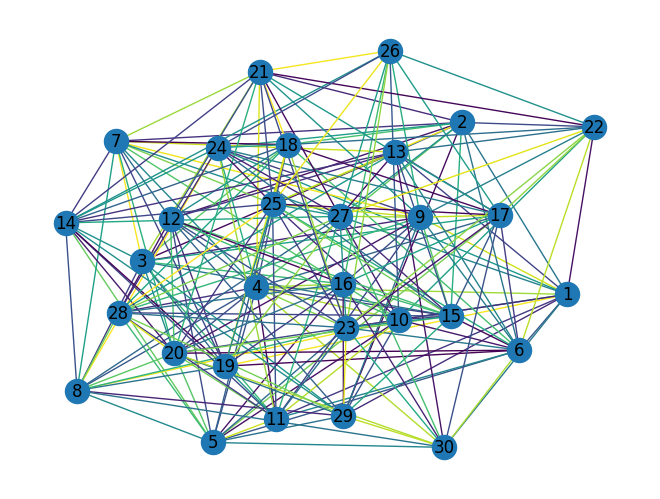

Time taken: 86.48675656318665 seconds

Running test graph_273_edges.txt...
Minimum edge coloring found.
Number of colors: 183
Number of iterations: 705


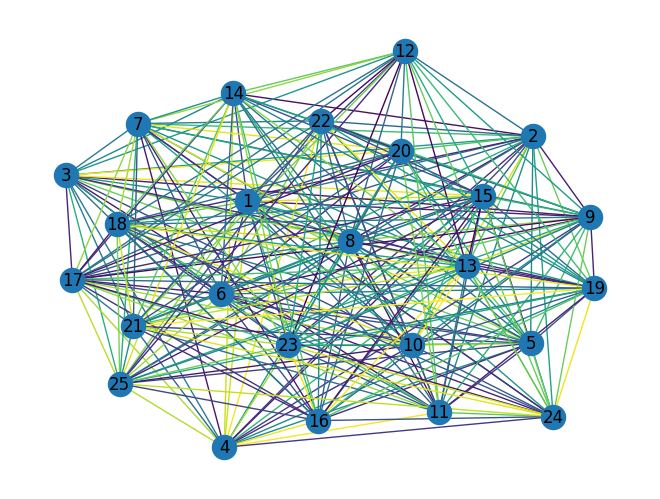

Time taken: 159.5253462791443 seconds

Running test graph_275_edges.txt...
Minimum edge coloring found.
Number of colors: 172
Number of iterations: 290


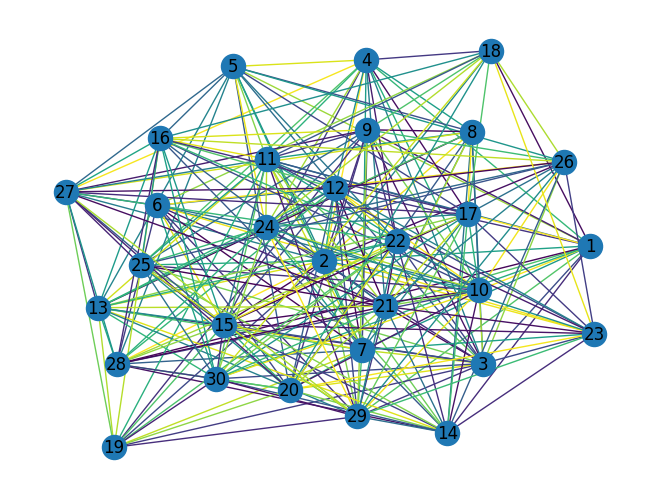

Time taken: 104.22635555267334 seconds



In [15]:
with open('./results/vns_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')